In [46]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import matplotlib.pyplot as plt
from matplotlib import gridspec


import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, SpatialDropout2D, Activation, Flatten
from tensorflow.keras.models import Model
import tensorflow as tf

import numpy as np
import pandas as pd
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing import image_dataset_from_directory

import keras
import glob


# Pre-processing

In [47]:
def preprocess_segmentation_mask(segmentation_mask):
    """preprocess the semgentation mask

    The original segmentation mask has three categories.
      foreground, background and outline
    This function will just convert it to foreground and background 

    The original segmentation mask is also 1-index, so will convert it
    to 0-index.

    the original mask is represented as:
    1 - edge of dog/cat and things like leashes etc.
    2 - background
    3 - foreground

    we want to just keep the merge the edges and foreground of the doggo/catto, and
    then treat it as a binary semantic segmentation task.
    To achieve this, we will just subtract two, converting to values of [-1, 0, 1],
    and then apply the abs function to convert the -1 values (edges) to the foreground.

    Will also convert it to 32 bit float which will be needed for working with tf.
    
    Why am I doing it this way?
     A reasonable question. Initially I tried to do it with just normal array indexing,
     but this is a bit more work since the mask is a tensorflow tensor and not a np array.
     We could alternatively convert it to an array, perform indexing and then map it back,
     but this would have a performance overhead, which wouldn't be a big deal, but still.
     With all that being said, I am doing it for you, so you don't have to.

    Args:
      segmentation_mask (array):
        original segmentation mask

    Returns:
      preprocessed segmentation_mask
    """
    return tf.abs(tf.cast(segmentation_mask, tf.float32) - 2)

def return_image_label_mask(ds_out):
    """ function to return image, class label and segmentation mask

    The original dataset contains additional information, such as the filename and
    the species. We don't care about any of that for this work, so will
    discard them and just keep the original image as our input, and then
    a tuple of our outputs that will be the class label and the semantic
    segmentation mask.

    Whilst we are here, we will also preprocess the segmentation mask.

    Args:
      ds_out: dict
        original dataset output

    Returns:
       RGB image
       tuple of class label and preprocessed segmentation mask
    """
    # preprocess the segmentation mask
    seg_mask =  preprocess_segmentation_mask(ds_out['segmentation_mask'])
    image = tf.cast(ds_out['image'], tf.float32)
    # image = standardise_image(image)
    return image, (ds_out['label'], seg_mask)

In [48]:
import tensorflow_addons as tfa

def random_rotations(x, y, max_rotation=0.785398):
    """apply random rotations to predictor variable and my autoencoder target"""
    rot_val = tf.random.uniform((), minval=-max_rotation, maxval=max_rotation)
    image = tfa.image.rotate(x, rot_val, fill_mode='nearest')
    mask = tfa.image.rotate(y[1], rot_val, fill_mode='nearest')
    return image, (y[0], mask)

def load_oxford_pets(split,
                     batch_size=233,
                     shuffle=True,
                     image_size=300):
    """Load Oxford pets dataset for Assignment 1B

    Function handles loading of data for 1b, included processing of images and
    semantic segmentation masks. This function will
    organise the tensorflow dataset to return an output that is a tuple, where
    the tuple will be (classification_labels, segmentation_masks).

    Parameters
    ----------
    split : string
        either train or test string
    batch_size : int
        size of batches to use
    shuffle : bool
        whether to shuffle the dataset (WILL ONLY APPLY TO TRAIN)
    image_size : int
        new image size

    Returns
    -------
       tf.Dataset containing the Oxford pets dataset
    """
    # lets do some error checking first
    if (split != 'train') and (split != 'test'):
        raise ValueError('Arg for split must be either \'train\' or \'test\'')
    if (split == 'test') and shuffle:
        print("WARNING: shuffle is set to true, but have specified split to be \'test\'")
        print('The shuffle argument will be ignored')
        shuffle = False
   
    # now start loading the dataset
    ds = tfds.load('oxford_iiit_pet',
                   split=split,
                   with_info=False)
    # remove unnecessary dataset info
    ds = ds.map(return_image_label_mask)

    # Apply random rotations
    ds = ds.map(random_rotations)
    
    # Final processing of the data 
    # here we will resize the data, and add the preprocessing that is needed 
    # and compatable with the mobilenet models.
    ds = ds.map(lambda inp, out: preprocess_and_resize(inp, out, image_size))

    if split == 'train' and shuffle:
        ds = ds.shuffle(1000)
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [49]:

def preprocess_and_resize(image, output, image_size):
    """apply preprocessing steps above to images and resize images and maps
    
    Each image in the dataset is of a different size. The resizing will make sure
    each image is the same size.
    """
    # resize the image and the semantic segmentation mask
    image = tf.image.resize(image, [image_size, image_size])
    image = mobilenet_preprocess_image(image)
    mask = tf.image.resize(output[1], [image_size, image_size])
    return image, (output[0], mask)


In [50]:
def mobilenet_preprocess_image(image):
    """Apply preprocessing that is suitable for MobileNetV3.
    
    Simply scales to ranges [-1, 1]
    
    
    you should use this preprocessing for both your model and the mobilenet model
    """
    image = (image - 127.5) / 255.0
    return image
    
    
def unprocess_image(image):
    """ undo preprocessing above so can plot images"""
    image = image * 255.0 + 127.5
    return image

In [51]:
# testing it and plotting some images.
# NOTE: the image size I am setting here is all but definitely too large. You will need
# to chage this yourself to something that is suitable given your constraints
# NOTE: The batch size is also too large. I am doing this on purpose to force you to 
# pick a suitable batch size yourself
image_size = 300
batch_size = 273
train_class_seg = load_oxford_pets('train', shuffle=True, batch_size=batch_size, image_size=image_size)
test_class_seg = load_oxford_pets('test', shuffle=False, batch_size=batch_size, image_size=image_size)

In [12]:
def resize_image_and_mask(image, outputs):
    resized_image = tf.image.resize(image, [128, 128])
    resized_mask = tf.image.resize(outputs[1], [128, 128])
    return resized_image, (outputs[0], resized_mask)

train_class_seg = train_dataset.map(resize_image_and_mask)
val_class_seg = val_dataset.map(resize_image_and_mask)
test_class_seg = test_class_seg.map(resize_image_and_mask)

In [13]:
def exclude_class_label(image, outputs):
    return image, outputs[1]  # Return only the image and mask

train_class_seg = train_class_seg.map(exclude_class_label)
val_class_seg = val_class_seg.map(exclude_class_label)
test_class_seg = test_class_seg.map(exclude_class_label)


# Model

In [29]:
image_size = 128

In [77]:
from tensorflow.keras import layers, models, callbacks
import tensorflow as tf

# Load pre-trained MobileNetV3
mobile_base = keras.applications.MobileNetV3Small(input_shape=(image_size, image_size, 3),
                                                  include_top=False,
                                                  include_preprocessing=False)

# Set up the base network / encoder to get embedding
inputs = layers.Input((128, 128, 3))
embedding = mobile_base(inputs)

# Classification output
flattened = layers.GlobalAveragePooling2D(name='gap')(embedding)
classification = layers.Dense(37, activation='softmax', name='classification')(flattened)

# Decoder
x = layers.UpSampling2D((3, 3))(embedding)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.SpatialDropout2D(0.2)(x)

x = layers.UpSampling2D((3, 3))(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.SpatialDropout2D(0.2)(x)

x = layers.UpSampling2D((3, 3))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.SpatialDropout2D(0.2)(x)

# Output for binary semantic segmentation - one channel
x = layers.Conv2D(1, (1, 1), activation=None, padding='same')(x)
segmentation = layers.Resizing(128, 128, name='segmentation')(x)

# Define model
model5 = models.Model(inputs=inputs, outputs=[classification, segmentation])

In [75]:
import csv
import numpy as np
import os

class CustomSaveCallback(tf.keras.callbacks.Callback):
    def __init__(self, filepath, validation_data, epoch_offset=0):
        super(CustomSaveCallback, self).__init__()
        self.filepath = filepath
        self.validation_data = validation_data
        self.epoch_offset = epoch_offset
        
        # Check if file already exists
        file_exists = os.path.exists(f"{self.filepath}/accuracies.csv")
        
        # Create or append to the CSV file
        file_mode = "a" if file_exists else "w"
        with open(f"{self.filepath}/accuracies.csv", file_mode, newline='') as f:
            writer = csv.writer(f)
            # If it's a new file, write the header
            if not file_exists:
                writer.writerow(["Epoch", "Segmentation Accuracy"])

    def on_epoch_end(self, epoch, logs=None):
        # Adjust epoch with the offset
        adjusted_epoch = epoch + self.epoch_offset
    
        # Save the model
        self.model.save(f"{self.filepath}/model_at_epoch_{adjusted_epoch + 1}.h5")
        
        # Predict the segmentation masks using the model
        _, seg_preds = self.model.predict(self.validation_data)
        
        # Extract true masks from the validation data
        true_masks = np.concatenate([y[1].numpy() for x, y in self.validation_data], axis=0)
    
        seg_preds_flat = (seg_preds.reshape(-1) > 0.5).astype(int)
        true_masks_flat = (true_masks.reshape(-1) > 0.5).astype(int)
    
        # Compute the confusion matrix
        cm = confusion_matrix(true_masks_flat, seg_preds_flat)
    
        # Retrieve the segmentation accuracy from logs
        seg_accuracy = logs['segmentation_accuracy']
    
        # Check if the combined CSV already exists
        file_exists = os.path.exists(f"{self.filepath}/segmentation_metrics_epoch_{adjusted_epoch + 1}.csv")
    
        # Write to the combined CSV
        file_mode = "a" if file_exists else "w"
        with open(f"{self.filepath}/segmentation_metrics_epoch_{adjusted_epoch + 1}.csv", file_mode, newline='') as f:
            writer = csv.writer(f)
            # If it's a new file, write the header
            if not file_exists:
                writer.writerow(["Epoch", "Segmentation Accuracy", "True Positives", "False Positives", "False Negatives", "True Negatives"])
            # Assuming the confusion matrix structure: [[TP, FP], [FN, TN]]
            writer.writerow([adjusted_epoch + 1, seg_accuracy, cm[0,0], cm[0,1], cm[1,0], cm[1,1]])


In [63]:
image_size =  128
train_class_seg = load_oxford_pets('train', shuffle=True, batch_size=273, image_size=image_size)
test_class_seg = load_oxford_pets('test', shuffle=False, batch_size=batch_size, image_size=image_size)

train_ratio = 0.8  # 80% for training, 20% for validation
train_size = int(train_ratio * len(train_class_seg))
val_size = len(train_class_seg) - train_size

print(train_size)
print(val_size)

train_dataset = train_class_seg.take(train_size)
val_dataset = train_class_seg.skip(train_size)



11
3


In [79]:
save_callback = CustomSaveCallback("tf-env/mxb362_models", test_class_seg)

# Initialize ModelCheckpoint
checkpoint = callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

# Initially freeze the base model
mobile_base.trainable = False

# Compile the model with appropriate loss functions
model5.compile(optimizer='adam',
               loss={'classification': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                     'segmentation': tf.keras.losses.BinaryCrossentropy(from_logits=True)},
               metrics={'classification': 'accuracy',
                        'segmentation': 'accuracy'})


history5_1 = model5.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,
    callbacks=[checkpoint, save_callback]
)

save_callback = CustomSaveCallback("tf-env/mxb362_models", test_class_seg, epoch_offset=20)

# Unfreeze the base model
mobile_base.trainable = True

# Re-compile the model
model5.compile(optimizer=tf.keras.optimizers.Adam(0.00001),  # Lower learning rate
               loss={'classification': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                     'segmentation': tf.keras.losses.BinaryCrossentropy(from_logits=True)},
               metrics={'classification': 'accuracy',
                        'segmentation': 'accuracy'})


history5_2 = model5.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=[checkpoint, save_callback]
)


Epoch 1/20


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


11/11 [==============================] - ETA: 0s - loss: 4.2947 - classification_loss: 3.7167 - segmentation_loss: 0.5780 - classification_accuracy: 0.0696 - segmentation_accuracy: 0.7215

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment



Epoch 1: val_loss improved from inf to 4.25500, saving model to best_model_2.h5


/Users/olivervu25/tf-env/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 58s 5s/step - loss: 4.2947 - classification_loss: 3.7167 - segmentation_loss: 0.5780 - classification_accuracy: 0.0696 - segmentation_accuracy: 0.7215 - val_loss: 4.2550 - val_classification_loss: 3.3610 - val_segmentation_loss: 0.8940 - val_classification_accuracy: 0.1093 - val_segmentation_accuracy: 0.7165
Epoch 2/20


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


11/11 [==============================] - ETA: 0s - loss: 3.4910 - classification_loss: 3.0708 - segmentation_loss: 0.4202 - classification_accuracy: 0.1832 - segmentation_accuracy: 0.8142

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment



Epoch 2: val_loss improved from 4.25500 to 3.52035, saving model to best_model_2.h5


/Users/olivervu25/tf-env/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 54s 5s/step - loss: 3.4910 - classification_loss: 3.0708 - segmentation_loss: 0.4202 - classification_accuracy: 0.1832 - segmentation_accuracy: 0.8142 - val_loss: 3.5204 - val_classification_loss: 2.7570 - val_segmentation_loss: 0.7634 - val_classification_accuracy: 0.2703 - val_segmentation_accuracy: 0.8008
Epoch 3/20


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


11/11 [==============================] - ETA: 0s - loss: 2.9713 - classification_loss: 2.5961 - segmentation_loss: 0.3752 - classification_accuracy: 0.3107 - segmentation_accuracy: 0.8371

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment



Epoch 3: val_loss improved from 3.52035 to 2.93417, saving model to best_model_2.h5


/Users/olivervu25/tf-env/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 54s 5s/step - loss: 2.9713 - classification_loss: 2.5961 - segmentation_loss: 0.3752 - classification_accuracy: 0.3107 - segmentation_accuracy: 0.8371 - val_loss: 2.9342 - val_classification_loss: 2.3793 - val_segmentation_loss: 0.5549 - val_classification_accuracy: 0.3560 - val_segmentation_accuracy: 0.8400
Epoch 4/20


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


11/11 [==============================] - ETA: 0s - loss: 2.5985 - classification_loss: 2.2429 - segmentation_loss: 0.3556 - classification_accuracy: 0.4109 - segmentation_accuracy: 0.8443

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment



Epoch 4: val_loss improved from 2.93417 to 2.54093, saving model to best_model_2.h5


/Users/olivervu25/tf-env/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 54s 5s/step - loss: 2.5985 - classification_loss: 2.2429 - segmentation_loss: 0.3556 - classification_accuracy: 0.4109 - segmentation_accuracy: 0.8443 - val_loss: 2.5409 - val_classification_loss: 2.0929 - val_segmentation_loss: 0.4480 - val_classification_accuracy: 0.4727 - val_segmentation_accuracy: 0.8472
Epoch 5/20


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


11/11 [==============================] - ETA: 0s - loss: 2.3212 - classification_loss: 1.9754 - segmentation_loss: 0.3458 - classification_accuracy: 0.4772 - segmentation_accuracy: 0.8472

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment



Epoch 5: val_loss improved from 2.54093 to 2.18265, saving model to best_model_2.h5


/Users/olivervu25/tf-env/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 54s 5s/step - loss: 2.3212 - classification_loss: 1.9754 - segmentation_loss: 0.3458 - classification_accuracy: 0.4772 - segmentation_accuracy: 0.8472 - val_loss: 2.1826 - val_classification_loss: 1.7883 - val_segmentation_loss: 0.3943 - val_classification_accuracy: 0.5524 - val_segmentation_accuracy: 0.8587
Epoch 6/20


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


11/11 [==============================] - ETA: 0s - loss: 2.1351 - classification_loss: 1.8019 - segmentation_loss: 0.3333 - classification_accuracy: 0.5178 - segmentation_accuracy: 0.8509

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment



Epoch 6: val_loss improved from 2.18265 to 2.05142, saving model to best_model_2.h5


/Users/olivervu25/tf-env/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 54s 5s/step - loss: 2.1351 - classification_loss: 1.8019 - segmentation_loss: 0.3333 - classification_accuracy: 0.5178 - segmentation_accuracy: 0.8509 - val_loss: 2.0514 - val_classification_loss: 1.7191 - val_segmentation_loss: 0.3323 - val_classification_accuracy: 0.5539 - val_segmentation_accuracy: 0.8618
Epoch 7/20


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


11/11 [==============================] - ETA: 0s - loss: 1.9926 - classification_loss: 1.6692 - segmentation_loss: 0.3234 - classification_accuracy: 0.5468 - segmentation_accuracy: 0.8542

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment



Epoch 7: val_loss improved from 2.05142 to 1.87886, saving model to best_model_2.h5


/Users/olivervu25/tf-env/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 54s 5s/step - loss: 1.9926 - classification_loss: 1.6692 - segmentation_loss: 0.3234 - classification_accuracy: 0.5468 - segmentation_accuracy: 0.8542 - val_loss: 1.8789 - val_classification_loss: 1.5379 - val_segmentation_loss: 0.3409 - val_classification_accuracy: 0.5761 - val_segmentation_accuracy: 0.8690
Epoch 8/20


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


11/11 [==============================] - ETA: 0s - loss: 1.8681 - classification_loss: 1.5507 - segmentation_loss: 0.3174 - classification_accuracy: 0.5871 - segmentation_accuracy: 0.8575

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment



Epoch 8: val_loss improved from 1.87886 to 1.80469, saving model to best_model_2.h5


/Users/olivervu25/tf-env/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 54s 5s/step - loss: 1.8681 - classification_loss: 1.5507 - segmentation_loss: 0.3174 - classification_accuracy: 0.5871 - segmentation_accuracy: 0.8575 - val_loss: 1.8047 - val_classification_loss: 1.5061 - val_segmentation_loss: 0.2986 - val_classification_accuracy: 0.6027 - val_segmentation_accuracy: 0.8675
Epoch 9/20


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


11/11 [==============================] - ETA: 0s - loss: 1.7924 - classification_loss: 1.4779 - segmentation_loss: 0.3146 - classification_accuracy: 0.6084 - segmentation_accuracy: 0.8588

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment



Epoch 9: val_loss improved from 1.80469 to 1.76247, saving model to best_model_2.h5


/Users/olivervu25/tf-env/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 55s 5s/step - loss: 1.7924 - classification_loss: 1.4779 - segmentation_loss: 0.3146 - classification_accuracy: 0.6084 - segmentation_accuracy: 0.8588 - val_loss: 1.7625 - val_classification_loss: 1.4594 - val_segmentation_loss: 0.3031 - val_classification_accuracy: 0.6115 - val_segmentation_accuracy: 0.8720
Epoch 10/20


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


11/11 [==============================] - ETA: 0s - loss: 1.7250 - classification_loss: 1.4142 - segmentation_loss: 0.3108 - classification_accuracy: 0.6210 - segmentation_accuracy: 0.8606

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment



Epoch 10: val_loss improved from 1.76247 to 1.68591, saving model to best_model_2.h5


/Users/olivervu25/tf-env/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 54s 5s/step - loss: 1.7250 - classification_loss: 1.4142 - segmentation_loss: 0.3108 - classification_accuracy: 0.6210 - segmentation_accuracy: 0.8606 - val_loss: 1.6859 - val_classification_loss: 1.3882 - val_segmentation_loss: 0.2977 - val_classification_accuracy: 0.6145 - val_segmentation_accuracy: 0.8686
Epoch 11/20


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


11/11 [==============================] - ETA: 0s - loss: 1.6547 - classification_loss: 1.3483 - segmentation_loss: 0.3064 - classification_accuracy: 0.6277 - segmentation_accuracy: 0.8618

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment



Epoch 11: val_loss improved from 1.68591 to 1.61958, saving model to best_model_2.h5


/Users/olivervu25/tf-env/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 53s 5s/step - loss: 1.6547 - classification_loss: 1.3483 - segmentation_loss: 0.3064 - classification_accuracy: 0.6277 - segmentation_accuracy: 0.8618 - val_loss: 1.6196 - val_classification_loss: 1.3239 - val_segmentation_loss: 0.2957 - val_classification_accuracy: 0.6484 - val_segmentation_accuracy: 0.8707
Epoch 12/20


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


11/11 [==============================] - ETA: 0s - loss: 1.5893 - classification_loss: 1.2848 - segmentation_loss: 0.3045 - classification_accuracy: 0.6577 - segmentation_accuracy: 0.8635

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment



Epoch 12: val_loss improved from 1.61958 to 1.59204, saving model to best_model_2.h5


/Users/olivervu25/tf-env/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 56s 5s/step - loss: 1.5893 - classification_loss: 1.2848 - segmentation_loss: 0.3045 - classification_accuracy: 0.6577 - segmentation_accuracy: 0.8635 - val_loss: 1.5920 - val_classification_loss: 1.3129 - val_segmentation_loss: 0.2792 - val_classification_accuracy: 0.6366 - val_segmentation_accuracy: 0.8770
Epoch 13/20


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


11/11 [==============================] - ETA: 0s - loss: 1.5905 - classification_loss: 1.2897 - segmentation_loss: 0.3008 - classification_accuracy: 0.6454 - segmentation_accuracy: 0.8646

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment



Epoch 13: val_loss improved from 1.59204 to 1.58006, saving model to best_model_2.h5


/Users/olivervu25/tf-env/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 54s 5s/step - loss: 1.5905 - classification_loss: 1.2897 - segmentation_loss: 0.3008 - classification_accuracy: 0.6454 - segmentation_accuracy: 0.8646 - val_loss: 1.5801 - val_classification_loss: 1.3036 - val_segmentation_loss: 0.2764 - val_classification_accuracy: 0.6189 - val_segmentation_accuracy: 0.8762
Epoch 14/20


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


11/11 [==============================] - ETA: 0s - loss: 1.5159 - classification_loss: 1.2159 - segmentation_loss: 0.3000 - classification_accuracy: 0.6693 - segmentation_accuracy: 0.8652

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment



Epoch 14: val_loss improved from 1.58006 to 1.49083, saving model to best_model_2.h5


/Users/olivervu25/tf-env/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 54s 5s/step - loss: 1.5159 - classification_loss: 1.2159 - segmentation_loss: 0.3000 - classification_accuracy: 0.6693 - segmentation_accuracy: 0.8652 - val_loss: 1.4908 - val_classification_loss: 1.2096 - val_segmentation_loss: 0.2813 - val_classification_accuracy: 0.6839 - val_segmentation_accuracy: 0.8724
Epoch 15/20


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


11/11 [==============================] - ETA: 0s - loss: 1.5037 - classification_loss: 1.2065 - segmentation_loss: 0.2972 - classification_accuracy: 0.6670 - segmentation_accuracy: 0.8667

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment



Epoch 15: val_loss did not improve from 1.49083


/Users/olivervu25/tf-env/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 54s 5s/step - loss: 1.5037 - classification_loss: 1.2065 - segmentation_loss: 0.2972 - classification_accuracy: 0.6670 - segmentation_accuracy: 0.8667 - val_loss: 1.5495 - val_classification_loss: 1.2630 - val_segmentation_loss: 0.2865 - val_classification_accuracy: 0.6484 - val_segmentation_accuracy: 0.8626
Epoch 16/20


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


11/11 [==============================] - ETA: 0s - loss: 1.4424 - classification_loss: 1.1472 - segmentation_loss: 0.2951 - classification_accuracy: 0.6830 - segmentation_accuracy: 0.8670

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment



Epoch 16: val_loss improved from 1.49083 to 1.46871, saving model to best_model_2.h5


/Users/olivervu25/tf-env/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 53s 5s/step - loss: 1.4424 - classification_loss: 1.1472 - segmentation_loss: 0.2951 - classification_accuracy: 0.6830 - segmentation_accuracy: 0.8670 - val_loss: 1.4687 - val_classification_loss: 1.1912 - val_segmentation_loss: 0.2775 - val_classification_accuracy: 0.6839 - val_segmentation_accuracy: 0.8703
Epoch 17/20


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


11/11 [==============================] - ETA: 0s - loss: 1.4259 - classification_loss: 1.1326 - segmentation_loss: 0.2933 - classification_accuracy: 0.6856 - segmentation_accuracy: 0.8677

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment



Epoch 17: val_loss improved from 1.46871 to 1.43205, saving model to best_model_2.h5


/Users/olivervu25/tf-env/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 53s 5s/step - loss: 1.4259 - classification_loss: 1.1326 - segmentation_loss: 0.2933 - classification_accuracy: 0.6856 - segmentation_accuracy: 0.8677 - val_loss: 1.4320 - val_classification_loss: 1.1564 - val_segmentation_loss: 0.2756 - val_classification_accuracy: 0.6706 - val_segmentation_accuracy: 0.8762
Epoch 18/20


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


11/11 [==============================] - ETA: 0s - loss: 1.3954 - classification_loss: 1.1060 - segmentation_loss: 0.2894 - classification_accuracy: 0.6870 - segmentation_accuracy: 0.8694

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment



Epoch 18: val_loss improved from 1.43205 to 1.40946, saving model to best_model_2.h5


/Users/olivervu25/tf-env/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 53s 5s/step - loss: 1.3954 - classification_loss: 1.1060 - segmentation_loss: 0.2894 - classification_accuracy: 0.6870 - segmentation_accuracy: 0.8694 - val_loss: 1.4095 - val_classification_loss: 1.1395 - val_segmentation_loss: 0.2700 - val_classification_accuracy: 0.6706 - val_segmentation_accuracy: 0.8770
Epoch 19/20


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


11/11 [==============================] - ETA: 0s - loss: 1.3794 - classification_loss: 1.0899 - segmentation_loss: 0.2895 - classification_accuracy: 0.6973 - segmentation_accuracy: 0.8700

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment



Epoch 19: val_loss improved from 1.40946 to 1.35741, saving model to best_model_2.h5


/Users/olivervu25/tf-env/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 53s 5s/step - loss: 1.3794 - classification_loss: 1.0899 - segmentation_loss: 0.2895 - classification_accuracy: 0.6973 - segmentation_accuracy: 0.8700 - val_loss: 1.3574 - val_classification_loss: 1.0895 - val_segmentation_loss: 0.2679 - val_classification_accuracy: 0.6913 - val_segmentation_accuracy: 0.8775
Epoch 20/20


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


11/11 [==============================] - ETA: 0s - loss: 1.3469 - classification_loss: 1.0594 - segmentation_loss: 0.2874 - classification_accuracy: 0.7010 - segmentation_accuracy: 0.8706

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment



Epoch 20: val_loss improved from 1.35741 to 1.33503, saving model to best_model_2.h5


/Users/olivervu25/tf-env/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 54s 5s/step - loss: 1.3469 - classification_loss: 1.0594 - segmentation_loss: 0.2874 - classification_accuracy: 0.7010 - segmentation_accuracy: 0.8706 - val_loss: 1.3350 - val_classification_loss: 1.0701 - val_segmentation_loss: 0.2650 - val_classification_accuracy: 0.7046 - val_segmentation_accuracy: 0.8709


Epoch 1/10


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


11/11 [==============================] - ETA: 0s - loss: 2.4163 - classification_loss: 2.0107 - segmentation_loss: 0.4056 - classification_accuracy: 0.4262 - segmentation_accuracy: 0.8196

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment



Epoch 1: val_loss improved from 1.33503 to 1.33438, saving model to best_model_2.h5


/Users/olivervu25/tf-env/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 71s 6s/step - loss: 2.4163 - classification_loss: 2.0107 - segmentation_loss: 0.4056 - classification_accuracy: 0.4262 - segmentation_accuracy: 0.8196 - val_loss: 1.3344 - val_classification_loss: 1.0689 - val_segmentation_loss: 0.2655 - val_classification_accuracy: 0.6736 - val_segmentation_accuracy: 0.8748
Epoch 2/10


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


11/11 [==============================] - ETA: 0s - loss: 2.3523 - classification_loss: 1.9547 - segmentation_loss: 0.3976 - classification_accuracy: 0.4339 - segmentation_accuracy: 0.8231

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment



Epoch 2: val_loss did not improve from 1.33438


/Users/olivervu25/tf-env/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 66s 6s/step - loss: 2.3523 - classification_loss: 1.9547 - segmentation_loss: 0.3976 - classification_accuracy: 0.4339 - segmentation_accuracy: 0.8231 - val_loss: 1.3853 - val_classification_loss: 1.1152 - val_segmentation_loss: 0.2702 - val_classification_accuracy: 0.6632 - val_segmentation_accuracy: 0.8740
Epoch 3/10


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


11/11 [==============================] - ETA: 0s - loss: 2.2859 - classification_loss: 1.8929 - segmentation_loss: 0.3931 - classification_accuracy: 0.4599 - segmentation_accuracy: 0.8242

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment



Epoch 3: val_loss improved from 1.33438 to 1.23131, saving model to best_model_2.h5


/Users/olivervu25/tf-env/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 66s 6s/step - loss: 2.2859 - classification_loss: 1.8929 - segmentation_loss: 0.3931 - classification_accuracy: 0.4599 - segmentation_accuracy: 0.8242 - val_loss: 1.2313 - val_classification_loss: 0.9659 - val_segmentation_loss: 0.2654 - val_classification_accuracy: 0.7282 - val_segmentation_accuracy: 0.8784
Epoch 4/10


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


11/11 [==============================] - ETA: 0s - loss: 2.2128 - classification_loss: 1.8313 - segmentation_loss: 0.3816 - classification_accuracy: 0.4719 - segmentation_accuracy: 0.8281

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment



Epoch 4: val_loss did not improve from 1.23131


/Users/olivervu25/tf-env/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 66s 6s/step - loss: 2.2128 - classification_loss: 1.8313 - segmentation_loss: 0.3816 - classification_accuracy: 0.4719 - segmentation_accuracy: 0.8281 - val_loss: 1.3058 - val_classification_loss: 1.0328 - val_segmentation_loss: 0.2731 - val_classification_accuracy: 0.7105 - val_segmentation_accuracy: 0.8787
Epoch 5/10


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


11/11 [==============================] - ETA: 0s - loss: 2.1711 - classification_loss: 1.8006 - segmentation_loss: 0.3705 - classification_accuracy: 0.4865 - segmentation_accuracy: 0.8336

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment



Epoch 5: val_loss did not improve from 1.23131


/Users/olivervu25/tf-env/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 67s 6s/step - loss: 2.1711 - classification_loss: 1.8006 - segmentation_loss: 0.3705 - classification_accuracy: 0.4865 - segmentation_accuracy: 0.8336 - val_loss: 1.2933 - val_classification_loss: 1.0199 - val_segmentation_loss: 0.2734 - val_classification_accuracy: 0.7105 - val_segmentation_accuracy: 0.8801
Epoch 6/10


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


11/11 [==============================] - ETA: 0s - loss: 2.1360 - classification_loss: 1.7677 - segmentation_loss: 0.3683 - classification_accuracy: 0.4845 - segmentation_accuracy: 0.8331

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment



Epoch 6: val_loss did not improve from 1.23131


/Users/olivervu25/tf-env/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 66s 6s/step - loss: 2.1360 - classification_loss: 1.7677 - segmentation_loss: 0.3683 - classification_accuracy: 0.4845 - segmentation_accuracy: 0.8331 - val_loss: 1.2998 - val_classification_loss: 1.0277 - val_segmentation_loss: 0.2721 - val_classification_accuracy: 0.7075 - val_segmentation_accuracy: 0.8824
Epoch 7/10


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


11/11 [==============================] - ETA: 0s - loss: 2.0897 - classification_loss: 1.7300 - segmentation_loss: 0.3597 - classification_accuracy: 0.5012 - segmentation_accuracy: 0.8368

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment



Epoch 7: val_loss did not improve from 1.23131


/Users/olivervu25/tf-env/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 66s 6s/step - loss: 2.0897 - classification_loss: 1.7300 - segmentation_loss: 0.3597 - classification_accuracy: 0.5012 - segmentation_accuracy: 0.8368 - val_loss: 1.2806 - val_classification_loss: 1.0017 - val_segmentation_loss: 0.2789 - val_classification_accuracy: 0.7075 - val_segmentation_accuracy: 0.8804
Epoch 8/10


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


11/11 [==============================] - ETA: 0s - loss: 2.0211 - classification_loss: 1.6664 - segmentation_loss: 0.3547 - classification_accuracy: 0.5191 - segmentation_accuracy: 0.8384

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment



Epoch 8: val_loss did not improve from 1.23131


/Users/olivervu25/tf-env/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 64s 6s/step - loss: 2.0211 - classification_loss: 1.6664 - segmentation_loss: 0.3547 - classification_accuracy: 0.5191 - segmentation_accuracy: 0.8384 - val_loss: 1.2716 - val_classification_loss: 0.9872 - val_segmentation_loss: 0.2844 - val_classification_accuracy: 0.6898 - val_segmentation_accuracy: 0.8781
Epoch 9/10


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


11/11 [==============================] - ETA: 0s - loss: 1.9729 - classification_loss: 1.6215 - segmentation_loss: 0.3514 - classification_accuracy: 0.5368 - segmentation_accuracy: 0.8411

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment



Epoch 9: val_loss did not improve from 1.23131


/Users/olivervu25/tf-env/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 64s 6s/step - loss: 1.9729 - classification_loss: 1.6215 - segmentation_loss: 0.3514 - classification_accuracy: 0.5368 - segmentation_accuracy: 0.8411 - val_loss: 1.2665 - val_classification_loss: 0.9761 - val_segmentation_loss: 0.2904 - val_classification_accuracy: 0.6957 - val_segmentation_accuracy: 0.8775
Epoch 10/10


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


11/11 [==============================] - ETA: 0s - loss: 1.9452 - classification_loss: 1.5956 - segmentation_loss: 0.3496 - classification_accuracy: 0.5365 - segmentation_accuracy: 0.8419

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment



Epoch 10: val_loss did not improve from 1.23131


/Users/olivervu25/tf-env/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 63s 6s/step - loss: 1.9452 - classification_loss: 1.5956 - segmentation_loss: 0.3496 - classification_accuracy: 0.5365 - segmentation_accuracy: 0.8419 - val_loss: 1.3437 - val_classification_loss: 1.0494 - val_segmentation_loss: 0.2942 - val_classification_accuracy: 0.6942 - val_segmentation_accuracy: 0.8769


In [18]:
test_class_seg = load_oxford_pets('test', shuffle=False, batch_size=batch_size, image_size=128)

checkpoint_path = "best_model_2.h5" 

best_model_2 = tf.keras.models.load_model(checkpoint_path)

loss, class_loss, seg_loss, class_accuracy, seg_accuracy = best_model_2.evaluate(test_class_seg)

print(f"Test accuracy: {class_accuracy*100}%")


14/14 [==============================] - 15s 984ms/step - loss: 1.6749 - classification_loss: 1.3857 - segmentation_loss: 0.2892 - classification_accuracy: 0.5824 - segmentation_accuracy: 0.8739
Test accuracy: 58.24475288391113%


In [16]:
for img, label in test_class_seg.take(1):
    print(img.shape)  # Should ideally match the model's input shape
    print(label.shape)  # Check if this matches the [4472832] from the error


(273, 128, 128, 3)
(273, 128, 128, 1)


14/14 [==============================] - 14s 942ms/step


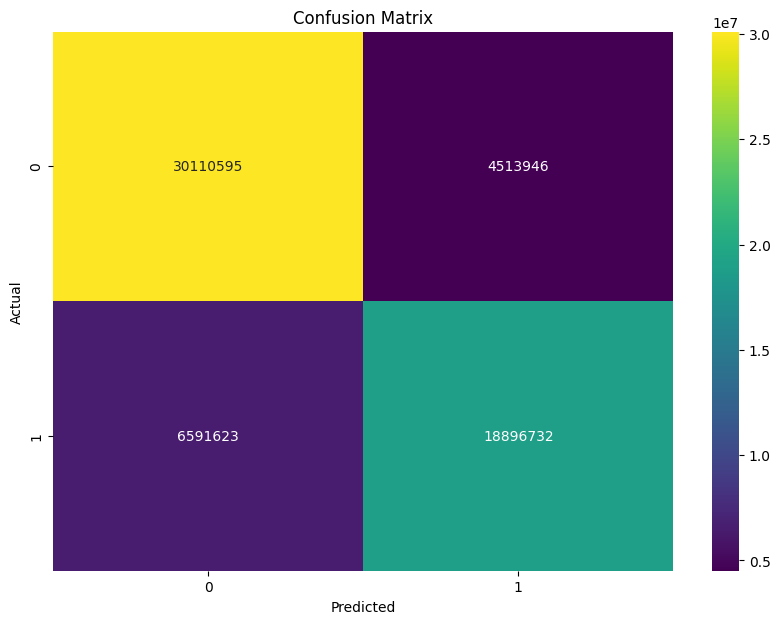

In [65]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predictions from the model
class_preds, seg_preds = best_model_2.predict(test_class_seg)
true_masks = np.concatenate([y[1].numpy() for x, y in test_class_seg], axis=0)

# Flatten the prediction and ground truth arrays and binarize them
seg_preds_flat = seg_preds.reshape(-1) > 0.5
true_masks_flat = true_masks.reshape(-1) > 0.5

# Calculate the confusion matrix
cm = confusion_matrix(true_masks_flat, seg_preds_flat)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap='viridis')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# Data Check

In [5]:
import pandas as pd

# Initialize a list to hold individual dataframes
dataframes = []

# Loop through each epoch
for epoch in range(1, 31):
    # Define the filepath based on the epoch
    filepath = f'tf-env/mxb362_models/segmentation_metrics_epoch_{epoch}.csv'
    
    # Read the current file
    current_data = pd.read_csv(filepath)
    
    # Add the current data to the list of dataframes
    dataframes.append(current_data)

# Concatenate all the dataframes in the list
all_data = pd.concat(dataframes, ignore_index=True)

# Display the first few rows of the combined data

all_data

,Epoch,Segmentation Accuracy,True Positives,False Positives,False Negatives,True Negatives
0,1,0.721536,19092375,15556271,2252539,23211711
1,2,0.814182,24132584,10559295,3459956,21961061
2,3,0.837079,27851948,6792096,5420155,20048697
3,4,0.844253,28905045,5764261,5938947,19504643
4,5,0.847153,29261196,5356578,6041328,19453794
5,6,0.850901,30246720,4414126,6948109,18503941
6,7,0.854176,29325699,5311861,5896899,19578437
7,8,0.857476,30756789,3898383,7362063,18095661
8,9,0.858764,30127353,4524237,6673683,18787623
9,10,0.860590,30615035,4077306,7076956,18343599
